In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import linalg
from collections.abc import Iterable

## PharmacoKinetics

In [2]:
def central_dydt(current_state, params):
    dC_dt = (params["k_dose"]*current_state["dose"]
            + sum(params["Q_perif"]*(current_state["peripheral"]/params["Vol_perif"]))
            - sum(params["Q_perif"]*(current_state["central"]/params["Vol_C"]))
            - params["Cl"]*(current_state["central"]/params["Vol_C"]))
    return dC_dt

def perif_dydt(current_state, params):
    dP_dt = (params["Q_perif"]*(current_state["central"]/params["Vol_C"])
            - params["Q_perif"]*(current_state["peripheral"]/params["Vol_perif"]))
    return dP_dt

def dose_iv(t):
    return 0
    
def PK_iv_dydt(y, t, param_values, comp=2):
    if comp==1:
        current_state= {'central': y, "peripheral":np.asarray([])}
        current_state["dose"] = dose_iv(t)
        params = {"k_dose" : 1, "Vol_C" : param_values[0], "Cl" : param_values[1], "Vol_perif" : np.asarray([]), "Q_perif" : np.asarray([])}
        
        dy_dt = central_dydt(current_state, params)
        
    else:
        current_state= {'central': y[0], "peripheral":np.asarray(y[1:])}
        current_state["dose"] = dose_iv(t)
        params= {"k_dose" : 1, "Vol_C" : param_values[0], "Cl" : param_values[1], "Vol_perif" : np.asarray(param_values[2]), "Q_perif" : np.asarray(param_values[3])}
        
        dC_dt = central_dydt(current_state, params)
        dP_dt = perif_dydt(current_state, params)
        dy_dt = np.insert(dP_dt, [0], [dC_dt])
    
    return dy_dt

def PK_iv_result(dose, num_comp, parameter, times):
    if len(parameter) != 2*num_comp:
        raise ValueError(
                'Number of Parameters does not match the number of Compartments')
    Vol_C = parameter[0]
    Cl = parameter[1]
    Vol_perif = parameter[2:num_comp+1]
    Q_perif = parameter[num_comp+1:]
    y_0 = [dose] +[0]*(num_comp-1)
    results_amt = integrate.odeint(PK_iv_dydt, y_0, times, args=((Vol_C, Cl, Vol_perif, Q_perif), num_comp))
    results_conc = results_amt/np.insert(Vol_perif, [0], Vol_C)
    return results_conc

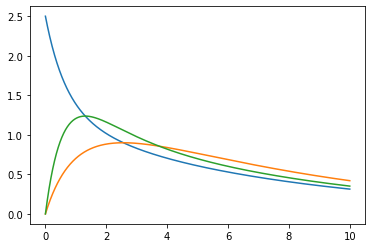

In [11]:
if __name__ == '__main__':
    # Params:
    k_dose = 1
    k_perif = 0.5
    Vol_perif = 1
    Cl = 0.5
    Vol_C = 2

    dose = 5
    time_span = 10
    times = np.linspace(0,time_span,1000)
    plt.plot(times, PK_iv_result(dose, 3, [Vol_C, Cl, Vol_perif, Vol_perif*0.5, k_perif, k_perif+0.1], times)[:,:])
    plt.show

### Analytical Solution

This is not neccessary for inferring the PK parameters but it will make calculating PD easier.

Real, Distinct Eigenvalues
0.46374582036475864
Real, Distinct Eigenvalues


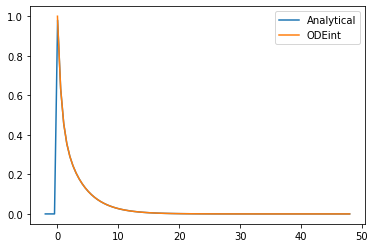

In [30]:
def solve_2_comp(dose, params, t):
    if isinstance(t, Iterable)==False and t<0:
        return 0
    else:
        Vol_C = params[0]
        Cl = params[1]
        Vol_perif = params[2]
        Q = params[3]

        A = np.asarray([[-(Cl+Q)/Vol_C, Q/Vol_perif], [Q/Vol_C, -Q/Vol_perif]])
        x_0 = np.array([dose, 0])
        eigvalues, eigvectors = linalg.eig(A)

        if eigvalues[0]==eigvalues[1]:
            print('Identical Eigenvalues')
            l = eigvalues[0]
            nu = eigvectors[0]
            rho = linalg.solve(A-l*np.identity(2), nu)
            c = linalg.solve([[nu[0], rho[0]],[nu[1], rho[1]]], x_0)
            C_t = c[0]*np.exp(l*t)*nu[0] + c[1]*(t*np.exp(l*t)*nu[0] +np.exp(l*t)*rho[0])
            
        elif eigvalues[0].imag == 0:
            print('Real, Distinct Eigenvalues')
            l1, l2 = eigvalues
            nu1, nu2 = eigvectors
            c = linalg.solve([[nu1[0], nu2[0]],[nu1[1], nu2[1]]], x_0)
            C_t = c[0]*np.exp(l1*t)*nu1[0] + c[1]*np.exp(l2*t)*nu2[0]
            
        else:
            print('Imaginary Eigenvalues')
            b = eigvalues[0].real
            a = eigvalues[0].imag
            nu = eigvectors[0]
            def u_v(time):
                ut_plus_ivt = np.exp(b*time)*(np.cos(a*time) + j*np.sin(b*time))*nu
                return (ut_plus_ivt.real, ut_plus_ivt.imag)
            
            u_0 = u_v(0)[0]
            v_0 = u_v(0)[1]
            c = linalg.solve([[u_0[0], v_0[0]],[u_0[1], v_0[1]]], x_0)
            C_t = c[0]*u_v(t)[0] + c[1]*u_v(t)[1]
        
        if isinstance(t, Iterable):
            times_before_dose = np.count_nonzero(t < 0)
            C_t[:times_before_dose] = 0
        return C_t.real/Vol_C

    
if __name__ == '__main__':
    
    Q_perif = 1
    Vol_perif = 1
    Cl = 1
    Vol_C = 2
    dose = 2
    print(solve_2_comp(2, [Vol_C, Cl, Vol_perif, Q_perif], 1))
    
    times = np.linspace(-2, 48, 100)
    times_before_dose = np.count_nonzero(times < 0)
    int_times = np.concatenate((np.zeros(1), times[times_before_dose:]))
    
    plt.plot(times, solve_2_comp(dose, [Vol_C, Cl, Vol_perif, Q_perif], times), label='Analytical')
    plt.plot(int_times, PK_iv_result(dose, 2, [Vol_C, Cl, Vol_perif, Q_perif], int_times)[:,0], label = 'ODEint')
    plt.legend()
    plt.show

## Pharmacodynamics

In [20]:
def proliferation_dydt(current_state):
    dProl_dt = (k_prol*current_state["Prol"]
                *(1-E_Drug(current_state["Conc"]))
                *np.power((Circ_0/current_state["Circ"]), gamma)
                - k_tr*current_state["Prol"])
    return dProl_dt
    
def transit_dydt(current_state):
    dT1_dt = k_tr*current_state["Prol"] - k_tr*current_state["T1"]
    dT2_dt = k_tr*current_state["T1"] - k_tr*current_state["T2"]
    dT3_dt = k_tr*current_state["T2"] - k_tr*current_state["T3"]
    return (dT1_dt, dT2_dt, dT3_dt)

def circulation_dydt(current_state):
    dCirc_dt = k_tr*current_state["T3"] - k_circ*current_state["Circ"]
    return dCirc_dt

def PD(y, t):
    variables = ["Prol", "T1", "T2", "T3", "Circ"]
    current_state = dict(zip(variables, y))
    current_state["Conc"] = drug_conc(t)
    # print(current_state)
    dProl_dt = proliferation_dydt(current_state)
    dCirc_dt = circulation_dydt(current_state)
    dT1_dt, dT2_dt, dT3_dt = transit_dydt(current_state)
    return [dProl_dt, dT1_dt, dT2_dt, dT3_dt, dCirc_dt]

In [21]:
def drug_conc(t):
    t_half = 7.5
    k = np.log(2)/t_half
    total_drug = 375
    C_ave = 1/72 * (total_drug - (1/k) * (1+np.exp(-72*k)))
    if t<0:
        conc = 0
    elif t<72:
        conc = C_ave*(1-np.exp(-k*t))
    else:
        conc = C_ave*np.exp(-k*(t-72))
    return conc

def E_Drug(conc):
    return slope*conc
    

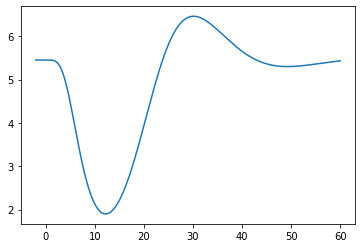

In [22]:
if __name__ == '__main__':
    # Params:
    Circ_0 = 5.45
    MTT = 135
    gamma = 0.174
    slope = 0.126

    n = 3
    k_tr = (n+1)/MTT
    k_prol = k_tr
    k_circ = k_tr


    times = np.linspace(-48,1440,1488)
    y_0 = [Circ_0]*5
    results = integrate.odeint(PD, y_0, times)
    plt.plot(times/24, results[:, 4])
    plt.show